In [12]:
import importlib
import pickle
from pathlib import Path

import numpy as np

from mapra import prep

WD = Path('.').resolve().parent


In [2]:
importlib.reload(prep)
data = prep.protherm_dataset()
df = data.dataframe_abbrev({'DATASET': 'reduced_set'})
seeds = np.random.default_rng(12345).integers(0, 1000, 20)
seeds

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:262: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:262: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/CAGI6/cam_mutants.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:262: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/reduced_set/ddg_test_set_332.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:262: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/fopra/elaspic-training-set-core.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:262: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapr

array([699, 227, 788, 316, 204, 797, 642, 676, 988, 391, 839, 332, 567,
       598, 213, 186, 229, 672, 613, 941])

In [3]:
splits = data.uniprot_train_test_split(df=df, test_size=.2, random_state=332)

loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0_protherm.pkl
split 332 targeted 0.2, real test sizes: 0.2020:0.2113:0.2057, record test sizes: 0.1612:0.1565:0.1544


In [4]:
ddg_test = splits['ddg'].test_set
ddg_test

{'O61594',
 'P00811',
 'P01006',
 'P02689',
 'P03034',
 'P09850',
 'P0A7Y4',
 'P0ACJ8',
 'P0AFG6',
 'P12528',
 'P23540',
 'P41500',
 'P69441',
 'P81708',
 'Q9EYL5'}

In [5]:
from Bio import SeqIO

records = dict()
ddg_wt_filename = next(Path('.').resolve().parent
                       .rglob('uniprot_prothermdb_delta_g_rep_seq.fasta'))
with open(ddg_wt_filename, 'r') as fasta:
    for record in SeqIO.parse(fasta, 'fasta'):
        records[record.id] = record
records

{'P02625': SeqRecord(seq=Seq('MSMTDLLSAEDIKKAIGAFTAADSFDHKKFFQMVGLKKKSADDVKKVFHILDKD...AES'), id='P02625', name='P02625', description='P02625', dbxrefs=[]),
 'P0A877': SeqRecord(seq=Seq('MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGADALELGIPF...TRS'), id='P0A877', name='P0A877', description='P0A877', dbxrefs=[]),
 'P00651': SeqRecord(seq=Seq('MMYSKLLTLTTLLLPTALALPSLVERACDYTCGSNCYSSSDVSTAQAAGYQLHE...ECT'), id='P00651', name='P00651', description='P00651', dbxrefs=[]),
 'P0AFG6': SeqRecord(seq=Seq('MSSVDILVPDLPESVADATVATWHKKPGDAVVRDEVLVEIETDKVVLEVPASAD...LDV'), id='P0AFG6', name='P0AFG6', description='P0AFG6', dbxrefs=[]),
 'P07751': SeqRecord(seq=Seq('MDPSGVKVLETAEDIQERRQQVLDRYHRFKELSSLRRQKLEDSYRFQFFQRDAD...FVN'), id='P07751', name='P07751', description='P07751', dbxrefs=[]),
 'O61594': SeqRecord(seq=Seq('MKLLVVLSLVAVACNASIVRQQRRFPDDFLFGTATASYQIEGAWDEDGKGENIW...EGH'), id='O61594', name='O61594', description='O61594', dbxrefs=[]),
 'Q13526': SeqRecord(seq=Seq('MADEEKLPPGWEKRMSRSSGRVYYFNHI

In [6]:
with open(ddg_wt_filename.with_name('ddg_test_set_332.fasta'), 'w') as fasta:
    for ddg_wt in ddg_test:
        SeqIO.write(records[ddg_wt], fasta, 'fasta')

In [7]:
len(ddg_test)


15

In [8]:
import numpy as np
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
from numpy.random import default_rng
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

sns.set_theme(style='white')
cmap = sns.color_palette('viridis', 3)

### evaluate performance on the testing set

dtemp ddg h2o 

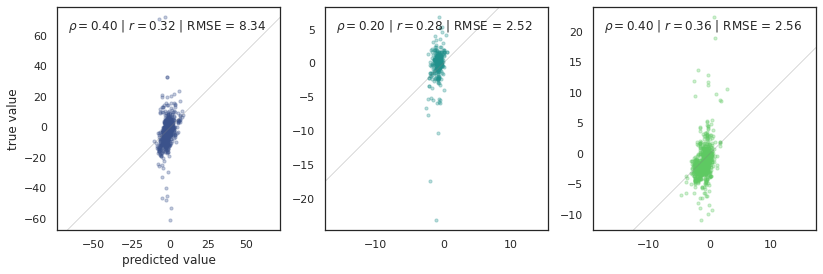

In [9]:
ars = list()
for i, (delta, split) in enumerate(splits.items()):
    print(f'{delta} ', end='')
    regr = linear_model.LassoLarsCV(n_jobs=-1, max_iter=1000, cv=5)
    regr.fit(split.X, split.y.flatten())

    # make a prediction
    y_pred = regr.predict(split.X_test).reshape(-1, 1)
    # save the prediction
    ars.append(np.hstack((np.full(y_pred.shape, i), y_pred, split.y_true)))

fig, axes = plt.subplots(1, 3, figsize=(13.6, 6))

for i, (ax, ar) in enumerate(zip(axes, ars)):
    sns.regplot(ax=ax,
                x=ar[:, 1], y=ar[:, 2],
                color=cmap[i],
                # marker='+',
                scatter_kws={'s': 10, 'alpha': .3},
                fit_reg=False, logistic=True)

    ax.set(aspect=1, box_aspect=1)
    # ax.set(title=data.tex_lookup[delta] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i])
    ax.axline((0, 0), slope=1, lw=.5, color='.5', alpha=.6)

    # correlations
    sp, pval = scipy.stats.spearmanr(ar[:, 1:], axis=0)
    pcorr = np.corrcoef(ar[:, 1:], rowvar=False)[0, 1]
    rmse = mean_squared_error(ar[:, 2], ar[:, 1], squared=False)
    r2 = r2_score(ar[:, 2], ar[:, 1])

    ax.text(.05, .9, r"$\rho = $" + f'{sp:.2f} | ' + r"$r = $" + f'{pcorr:.2f} | RMSE = {rmse:.2f}',
            transform=ax.transAxes)
    # axes[0].set_title(desc % test_size, loc='left', fontsize='xx-large', pad=12)

# fig.subplots_adjust(bottom=0.002)
axes[0].set(ylabel='true value', xlabel='predicted value')
prep.save(fig, f'uniprot_332.svg')

### save the testing set

In [13]:
with open(WD / 'fopra' / f'test_set_332.pkl', 'wb') as pkl:
    pickle.dump(splits, pkl)

# ... maybe easier to re-generate on-the-fly?

AttributeError: Can't pickle local object 'dataset.uniprot_train_test_split.<locals>.Split'